# 3. Quantify extracellular RNA

After defining extracellular transcripts (previous notebooks), we will now focus on characterizing and quantifying the presence of exRNA for the different genes profiled in the dataset employing different strategies and tests

## Import packages

In [1]:
import spatialdata as sd

import troutpy

/ictstr01/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/troutpy-env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/ictstr01/home/icb/raphael.kfuri-rubens/miniforge-pypy3/envs/troutpy-env/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Read the SpatialData object

We read the processed Spatialdata object, which was previously stored as .zarr

In [2]:
xenium_path_cropped = "/lustre/groups/ml01/datasets/projects/2025_sergio_troutpy/example_datasets/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

## Testing for expression over noise levels

We implemented `troutpy.tl.quantify_overexpression` to identify **overexpressed genes relative to a noise threshold**.

Essentially, it computes a threshold based on the counts of specified control features and compares gene counts against this threshold to determine overexpression. The function calculates log-fold changes for each gene, annotates metadata with these results. It returns updated spatial data along with per-gene scores and the calculated threshold

In [9]:
sdata["xrna_metadata"].var["feature_name"] = sdata["xrna_metadata"].var.index

In [12]:
sdata["xrna_metadata"].var.drop(columns=['count', 'control_probe', 'logfoldratio_over_noise'], inplace=True)

In [14]:
control_codewords = ["negative_control_probe", "unassigned_codeword", "deprecated_codeword", "genomic_control_probe", "negative_control_codeword"]

troutpy.tl.quantify_overexpression(
    sdata,
    layer="transcripts",
    codeword_column="codeword_category",
    control_codewords=control_codewords,
    gene_id_column="feature_name",
    percentile_threshold=99.99,
)

## Testing for proportion of extracellular transcripts

The `troutpy.tl.extracellular_enrichment` function computes the proportions of extracellular and intracellular transcripts for each gene. 

Essentially, the function calculates: (1) the proportion of transcripts of each gene present extracellularly and (2) the log fold change of extracellular to intracellular proportions.  These results into the `sdata` object under the `xrna_metadata` layer.

In [16]:
sdata["xrna_metadata"].var.drop(columns=['extracellular_proportion', 'intracellular_proportion','logfoldratio_extracellular'], inplace=True)

In [17]:
troutpy.tl.extracellular_enrichment(sdata)

## Testing for Spatial Variability

The `troutpy.tl.spatial_variability` function quantifies the spatial variability of extracellular RNA using Moran's I, a metric for spatial autocorrelation.

In [18]:
troutpy.tl.spatial_variability(sdata, gene_id_key="feature_name", coords_keys=["x", "y"], n_neighbors=10, binsize=20)

Extracting gene counts: 100%|██████████| 13031/13031 [00:00<00:00, 20430.54it/s]


## Testing for local density

The `spatial_colocalization` function evaluates the spatial colocalization of extracellular RNA transcripts in spatial transcriptomics data by identifying regions where transcripts from the same or different genes are found in close proximity. The function calculates the proportion of colocalized transcripts for each gene, using a user-defined threshold to define colocalization, and integrates these results into the metadata of the dataset for downstream analysis.

The function calculates the proportion of colocalized transcripts for each gene based on a user-defined threshold, leveraging kernel density estimation to compute spatial gene expression densities. Results are integrated into the `sdata` object under the `xrna_metadata` layer.

In [19]:
troutpy.tl.spatial_colocalization(
    sdata, coords_keys=["x", "y"], gene_id_key="feature_name", resolution=1000, binsize=5, threshold_colocalized=1, copy=False
)

Extracting gene counts: 100%|██████████| 13031/13031 [00:02<00:00, 5735.38it/s]


## Save SpatialData as zarr

The resulting dataset is finally stored in a new zarr object

In [10]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr). Please see the 
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr the new file path:               
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr                                    


### ---TO DO--- Create visualization for the output of different tests

In [42]:
xenium_path_cropped = "/lustre/groups/ml01/datasets/projects/2025_sergio_troutpy/example_datasets/mousebrain_prime_crop_communication.zarr"
sdata=sd.read_zarr(xenium_path_cropped)

In [43]:
exrna_metrics = sdata["xrna_metadata"].var
# This ones are the most interesting ones, but others can be used
exrna_metrics_filt = exrna_metrics.loc[:, ["logfoldratio_over_noise", "logfoldratio_extracellular", "moran_I", "proportion_of_colocalized"]]

#### PLOTTING FUNCTION 1 (troutpy.pl)- lfr_over_noise grouped by gene type
- **Aim**: Represent the logfoldratio over noise for different genes
- **Input**: sdata["xrna_metadata"].var
- **Suggested Type of plot**: Either barplot, violin or stripplot, representing logfoldration over noise (`sdata["xrna_metadata"]['logfoldratio_over_noise']`),  grouping genes in based on wether they are control probes or not (in sdata["xrna_metadata"].var['control_probe'] column)
-  **Returns**: None (besides the plot) 

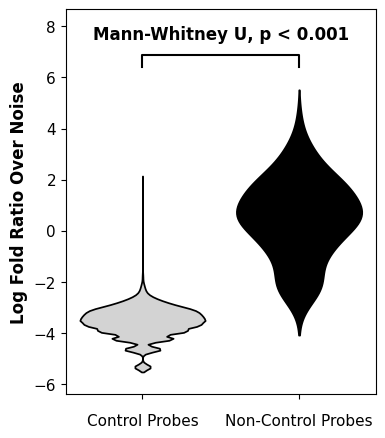

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, mannwhitneyu, shapiro
import spatialdata as sd
from typing import Optional

def logfoldratio_over_noise(
    sdata: sd.SpatialData,
    non_control_probes: Optional[list[str]] = None,
    test_method: str = "auto"
) -> None:
    """
    Creates a violin plot comparing logfoldratio_over_noise values for control
    vs non-control probes, and tests for significance using the specified test.

    Parameters
    ----------
    sdata: SpatialData object that contains 'xrna_metadata' with 'var' DataFrame.
    non_control_genes: List of specific non-control genes to include in the
    analysis (default: all).
    test_method: Statistical test to use. Options:
                 - "t-test" → Welch's t-test
                 - "mannwhitney" → Mann-Whitney U-test
                 - "auto" (default) → Chooses test based on normality test
    """  # noqa: D205
    var_df = sdata["xrna_metadata"].var.copy()

    var_df["control_probe"] = var_df["control_probe"].map(
        {True: "Control Probes", False: "Non-Control Probes"}
    )
    var_df["control_probe"] = pd.Categorical(
        var_df["control_probe"],
        categories=["Control Probes", "Non-Control Probes"],
        ordered=True
    )

    if non_control_probes is not None:
        var_df = var_df[
            (var_df["control_probe"] == "Control Probes")
            | (var_df.index.isin(non_control_probes))
        ]

    control_values = var_df[
        var_df["control_probe"] == "Control Probes"
        ]["logfoldratio_over_noise"]
    non_control_values = var_df[
        var_df["control_probe"] == "Non-Control Probes"
        ]["logfoldratio_over_noise"]

    var_df["logfoldratio_over_noise"] = (
        var_df["logfoldratio_over_noise"]
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )

    if test_method == "auto":
        control_normal = shapiro(control_values).pvalue > 0.05
        non_control_normal = shapiro(non_control_values).pvalue > 0.05
        if control_normal and non_control_normal:
            test_method = "t-test"
        else:
            test_method = "mannwhitney"

    if test_method == "t-test":
        stat, p_value = ttest_ind(
            control_values,
            non_control_values,
            equal_var=False
        )  # welch's t-test
        test_used = "t-test"
    elif test_method == "mannwhitney":
        stat, p_value = mannwhitneyu(
            control_values,
            non_control_values,
            alternative="two-sided"
        )
        test_used = "Mann-Whitney U"
    else:
        raise ValueError(
            "Invalid test_method. Choose from 't-test', 'mannwhitney' or 'auto'."
        )

    plt.figure(figsize=(4, 5))
    sns.violinplot(
        x="control_probe", y="logfoldratio_over_noise",
        data=var_df, palette=["lightgrey", "black"],
        inner=None,
        order=["Control Probes", "Non-Control Probes"]
    )

    y_max = max(var_df["logfoldratio_over_noise"]) * 1.5
    plt.ylim(min(var_df["logfoldratio_over_noise"]) * 1.2, y_max * 1.35)

    x1, x2 = 0, 1
    plt.plot(
        [x1, x1, x2, x2],
        [y_max, y_max * 1.07, y_max * 1.07, y_max],
        lw=1.5,
        color="black"
    )

    sig_text = (
        f"{test_used}, p = {p_value:.3e}"
        if p_value >= 0.001
        else f"{test_used}, p < 0.001"
    )
    plt.text(
        (x1 + x2) / 2, y_max * 1.14,
        sig_text,
        ha="center",
        va="bottom",
        fontsize=12,
        fontweight="bold"
    )

    plt.xlabel("")
    plt.ylabel("Log Fold Ratio Over Noise", fontsize=12, fontweight="bold")
    plt.gca().xaxis.set_tick_params(pad=10)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)

    plt.show()

logfoldratio_over_noise(
    sdata,
    non_control_probes=sdata["xrna_metadata"].var.index[:100].tolist(),
    test_method="auto"
)

#### PLOTTING FUNCTION 2 (troutpy.pl) Sorted scatterplot/barplot 
- **Aim**: Represent, for a given metric, the genes sorted by them. (the logfoldratio extracellular or extracellular_proportion). Maybe highlighting top-bottom genes with highest-lower scores
- **Input**: sdata -- from which all info needed will be under `sdata["xrna_metadata"].var`, the name column in `sdata["xrna_metadata"].var` (str) (e.g. 'moran_i','extracellular_proportion')
- **Suggested Type of plot**: Either sorted scatter plot, stripplot,barplot or similar, representing extracellular proportion over genes. Maybe color based on  sdata["xrna_metadata"].var['control probe']
- **Return**: None

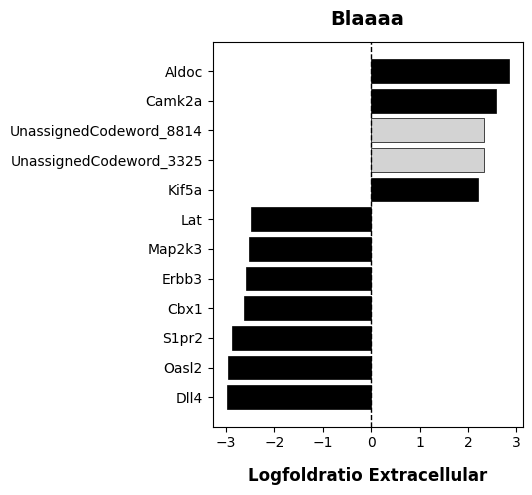

In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Optional
import spatialdata as sd

def top_bottom_probes_of_metric(
    sdata: sd.SpatialData,
    metric: str,
    top_n: int = 10,
    bottom_n: int = 10,
    title: Optional[str] = None
) -> None:
    """
    Creates a horizontal bar plot showing the top and bottom genes based on a
    specified metric. Bars are colored based on whether the gene is a control
    probe or not.

    Parameters
    ----------
    sdata : sd.SpatialData
        SpatialData object that contains 'xrna_metadata' with 'var' DataFrame.

    metric : str
        The metric to sort genes by. Must be one of:
        - "logfoldratio_extracellular"
        - "extracellular_proportion"
        - "moran_I"
        - "proportion_of_colocalized"
        - "intracellular_proportion"

    top_n : int, default=10
        The number of top genes to display.

    bottom_n : int, default=10
        The number of bottom genes to display.

    Returns
    -------
    None
        Displays a horizontal bar plot.
    """  # noqa: D205
    var_df = sdata["xrna_metadata"].var.copy()

    valid_metrics = {
        "logfoldratio_extracellular",
        "extracellular_proportion",
        "moran_I",
        "proportion_of_colocalized",
        "intracellular_proportion",
    }
    if metric not in valid_metrics:
        raise ValueError(f"Invalid metric. Choose from: {', '.join(valid_metrics)}")

    var_df[metric] = var_df[metric].replace([np.inf, -np.inf], np.nan).dropna()

    top_genes = (
        var_df.nlargest(top_n, metric)
        if top_n > 0
        else pd.DataFrame(columns=[metric])
    )
    bottom_genes = (
        var_df.nsmallest(bottom_n, metric)
        if bottom_n > 0
        else pd.DataFrame(columns=[metric])
    )

    plot_df = pd.concat([bottom_genes, top_genes])
    if plot_df.empty:
        raise ValueError("No valid genes found for the selected metric.")

    plot_df = plot_df.sort_values(by=metric)

    colors = (
        plot_df["control_probe"]
        .map({True: "lightgrey", False: "black"})
        .tolist()
    )

    plt.figure(figsize=(4, max(5, len(plot_df) * 0.4)))
    plt.barh(
        y=plot_df.index,
        width=plot_df[metric],
        color=colors,
        edgecolor="black",
        linewidth=0.5
    )

    plt.xlabel(
        metric.replace("_", " ").title(),
        fontsize=12,
        fontweight="bold",
        labelpad=12
    )
    plt.ylabel("")
    plt.title(title if title else "", fontsize=14, fontweight="bold", pad=12)
    plt.axvline(0, color="black", linestyle="--", linewidth=1)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

top_bottom_probes_of_metric(
    sdata,
    metric="logfoldratio_extracellular",
    top_n=5,
    bottom_n=7,
    title="Blaaaa"
)

#### PLOTTING FUNCTION 3 (troutpy.pl)- Scatterplot
- **Aim**: For each gene, represent two of the metrics side by side, in the form of a scatter plot
- **Input**: sdata -- from which all info needed will be under sdata["xrna_metadata"].var, x and y axes
- **Suggested Type of plot**: Scatterplot, maybe colored by control probe column as well
(sdata["xrna_metadata"].var['control probe'])
- **Return**: None

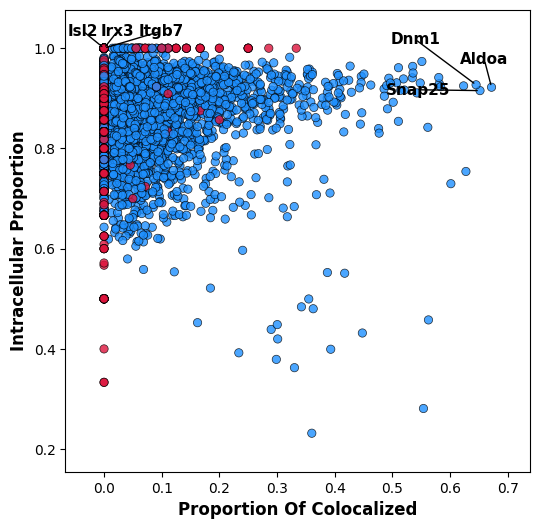

In [322]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from typing import Optional, List
import spatialdata as sd  # Assuming SpatialData is from this package
from adjustText import adjust_text  # Helps prevent overlapping labels

### TODO: adjustText has to be added to dependencies!!!!!!!!!!!!!!!!!

def plot_metric_scatter(
    sdata: sd.SpatialData,
    x_metric: str,
    y_metric: str,
    non_control_probes: Optional[List[str]] = None,
    label_top_n_x: int = 0,
    label_top_n_y: int = 0,
    title: Optional[str] = None
) -> None:
    """
    Creates a scatter plot of two specified metrics from a SpatialData object,
    highlighting control vs. non-control probes, with options to label top genes
    in each metric.

    Parameters
    ----------
    sdata : sd.SpatialData
        A SpatialData object containing 'xrna_metadata' with 'var' DataFrame.

    x_metric : str
        The metric to be plotted on the x-axis. Must be one of:
        - "logfoldratio_extracellular"
        - "extracellular_proportion"
        - "moran_I"
        - "proportion_of_colocalized"
        - "intracellular_proportion"

    y_metric : str
        The metric to be plotted on the y-axis. Must be one of the same valid
        options as `x_metric`.

    non_control_probes : Optional[List[str]], default=None
        A list of specific non-control probes to include in the plot.
        If None, all non-control probes are included.

    label_top_n_x : int, default=0
        The number of top genes based on `x_metric` to be labeled in the plot.

    label_top_n_y : int, default=0
        The number of top genes based on `y_metric` to be labeled in the plot.

    title : Optional[str], default=None
        A custom title for the plot. If None, a default title is generated using
        `x_metric` and `y_metric`.

    Returns
    -------
    None
        Displays a scatter plot of the two selected metrics.
    """  # noqa: D205
    var_df = sdata["xrna_metadata"].var.copy()

    # Validate metrics
    valid_metrics = {
        "logfoldratio_extracellular",
        "extracellular_proportion",
        "moran_I",
        "proportion_of_colocalized",
        "intracellular_proportion",
    }
    if x_metric not in valid_metrics or y_metric not in valid_metrics:
        raise ValueError(
            f"Invalid metric. Choose from: {', '.join(valid_metrics)}"
        )

    var_df[x_metric] = var_df[x_metric].replace([np.inf, -np.inf], np.nan)
    var_df[y_metric] = var_df[y_metric].replace([np.inf, -np.inf], np.nan)
    var_df.dropna(subset=[x_metric, y_metric], inplace=True)

    if non_control_probes is not None:
        var_df = var_df[
            (var_df["control_probe"] is True)
            | (var_df.index.isin(non_control_probes))
        ]

    colors = var_df["control_probe"].map({True: "#DC143C", False: "#1E90FF"})

    plt.figure(figsize=(6, 6))
    plt.scatter(
        var_df[x_metric],
        var_df[y_metric],
        c=colors,
        edgecolor="black",
        linewidth=0.5,
        alpha=0.8
    )

    label_genes = set()
    if label_top_n_x > 0:
        label_genes.update(var_df.nlargest(label_top_n_x, x_metric).index)
    if label_top_n_y > 0:
        label_genes.update(var_df.nlargest(label_top_n_y, y_metric).index)

    texts = []
    for gene in label_genes:
        texts.append(
            plt.text(
                var_df.loc[gene, x_metric],
                var_df.loc[gene, y_metric],
                gene,
                fontsize=11,
                ha="right",
                fontweight="bold"
            )
        )

    x_min, x_max = var_df[x_metric].min(), var_df[x_metric].max()
    y_min, y_max = var_df[y_metric].min(), var_df[y_metric].max()

    x_padding = (x_max - x_min) * 0.1
    y_padding = (y_max - y_min) * 0.1

    plt.xlim(x_min - x_padding, x_max + x_padding)
    plt.ylim(y_min - y_padding, y_max + y_padding)

    adjust_text(
        texts,
        arrowprops={"arrowstyle": "-", "color": 'black', "lw": 1},
        only_move={'points': 'xy', 'text': 'xy'},
        expand_points=(4, 4),
        expand_text=(5, 5),
        force_text=(5, 5),
        force_points=(6, 6),
        force_explode=(4, 4)
    )

    plt.xlabel(
        x_metric.replace("_", " ").title(), fontsize=12, fontweight="bold"
    )
    plt.ylabel(
        y_metric.replace("_", " ").title(), fontsize=12, fontweight="bold"
    )

    plt.title(
        title if title else "",
        fontsize=14, fontweight="bold"
    )

    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

    plt.show()

plot_metric_scatter(
    sdata,
    x_metric="proportion_of_colocalized",
    y_metric="intracellular_proportion",
    label_top_n_x=3,
    label_top_n_y=3
)

#### PLOTTING FUNCTION 4 (troutpy.pl)- Summary visualization
- **Aim**: Represent in a tabular plot (heatmap, dotplot) the overall score for individual genes on different metrics.
- **Input**: sdata -- from which all info needed will be under `sdata["xrna_metadata"].var`, list of columns in `sdata["xrna_metadata"].var`, maybe list of genes to be visualized? if all are too many.
- **Suggested Type of plot**: Heatmap, dotplot or similar. Take sc.pl.dotplot/ sc.tl.matrixplot as reference?
- **Return**: None

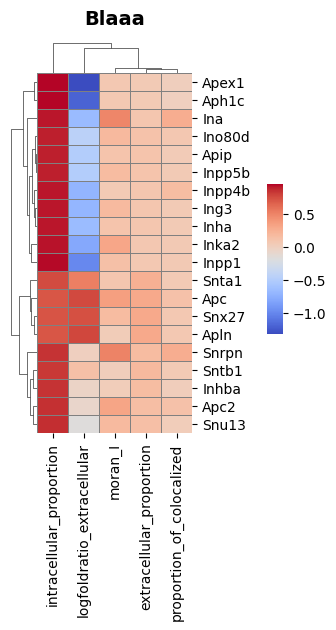

In [323]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from typing import Optional, List
import spatialdata as sd  # Assuming SpatialData is from this package

def plot_gene_metric_heatmap(
    sdata: sd.SpatialData,
    metrics: Optional[List[str]] = None,
    probes_to_plot: Optional[List[str]] = None,
    title: Optional[str] = None,
    cluster_axis: str = "both"
) -> None:
    """
    Creates a heatmap or clustered heatmap (with optional dendrogram) showing
    the overall scores of individual genes across different metrics.
    Automatically handles non-finite values by replacing inf/-inf with NaN
    and removing rows or columns that are entirely NaN.

    Parameters
    ----------
    sdata : sd.SpatialData
        A SpatialData object containing 'xrna_metadata' with 'var' DataFrame.

    metrics : Optional[List[str]], default=None
        A list of metric names to be plotted. If None, the following valid
        metrics are used:
        - "logfoldratio_extracellular"
        - "extracellular_proportion"
        - "moran_I"
        - "proportion_of_colocalized"
        - "intracellular_proportion"

    probes_to_plot : Optional[List[str]], default=None
        A list of specific probes (genes) to include in the heatmap. If None,
        all available genes are included.

    title : Optional[str], default=None
        A custom title for the plot. If None, a default title is generated.

    cluster_axis : str, default="both"
        Determines whether to show a dendrogram (via `sns.clustermap`):
        - "none" (no clustering, just a normal heatmap)
        - "x" (cluster columns only)
        - "y" (cluster rows only)
        - "both" (cluster rows and columns)

    Returns
    -------
    None
        Displays a heatmap (or clustermap) of the specified metrics for
        selected genes.
    """  # noqa: D205
    var_df = sdata["xrna_metadata"].var.copy()

    # Define valid metrics
    valid_metrics = {
        "logfoldratio_extracellular",
        "extracellular_proportion",
        "moran_I",
        "proportion_of_colocalized",
        "intracellular_proportion",
    }

    if metrics is None:
        metrics = list(valid_metrics)

    invalid_metrics = [m for m in metrics if m not in valid_metrics]
    if invalid_metrics:
        raise ValueError(
            f"The following metrics are not valid: {', '.join(invalid_metrics)}"
        )

    valid_axes = ["none", "x", "y", "both"]
    cluster_axis = cluster_axis.lower()
    if cluster_axis not in valid_axes:
        raise ValueError(
            f"Invalid cluster_axis: {cluster_axis}. "
            f"Must be one of {', '.join(valid_axes)}."
        )

    if probes_to_plot is not None:
        var_df = var_df[var_df.index.isin(probes_to_plot)]


    heatmap_data = var_df[metrics].replace([np.inf, -np.inf], np.nan)
    heatmap_data.dropna(how="all", axis=0, inplace=True)
    heatmap_data.dropna(how="all", axis=1, inplace=True)

    if heatmap_data.empty:
        print("No finite data available to plot.")
        return

    num_genes = heatmap_data.shape[0]
    show_ylabels = (probes_to_plot is not None) and (num_genes <= 20)

    ytick_colors = [
        "gray"
        if (gene in var_df.index and var_df.loc[gene, "control_probe"])
        else "black"
        for gene in heatmap_data.index
    ]

    if cluster_axis == "none":
        plt.figure(
            figsize=(len(heatmap_data.columns) * 0.4, max(5, num_genes * 0.2))
        )

        ax = sns.heatmap(
            heatmap_data,
            cmap="coolwarm",
            linewidths=0.5,
            linecolor="gray",
            annot=False,
            fmt=".2f",
            cbar=True,
            yticklabels=heatmap_data.index if show_ylabels else False
        )

        if show_ylabels:
            for tick_label, color in zip(
                ax.get_yticklabels(),
                ytick_colors, strict=False
            ):
                tick_label.set_color(color)

        ax.set_xlabel("", fontsize=12, fontweight="bold")
        ax.set_ylabel("", fontsize=12, fontweight="bold")

        final_title = title if title else ""
        ax.set_title(final_title, fontsize=14, fontweight="bold", pad=15)

        plt.show()

    else:
        row_cluster = cluster_axis in ["y", "both"]
        col_cluster = cluster_axis in ["x", "both"]

        g = sns.clustermap(
            data=heatmap_data,
            cmap="coolwarm",
            linewidths=0.5,
            linecolor="gray",
            annot=False,
            row_cluster=row_cluster,
            col_cluster=col_cluster,
            dendrogram_ratio=(0.15, 0.08),
            cbar_pos=(1.3, 0.4, 0.08, 0.3),
        )

        g.fig.set_size_inches(
            (len(heatmap_data.columns) * 0.4,
            max(5, heatmap_data.shape[0] * 0.1))
        )

        if not show_ylabels:
            g.ax_heatmap.set_yticklabels([])
        else:
            if row_cluster and g.dendrogram_row is not None:
                row_order = g.dendrogram_row.reordered_ind
                new_index = heatmap_data.index[row_order]
                for tick_label, gene in zip(
                    g.ax_heatmap.get_yticklabels(),
                    new_index, strict=False
                ):
                    color = (
                        "gray"
                        if (
                            gene in var_df.index
                            and var_df.loc[gene, "control_probe"]
                        )
                        else "black"
                    )
                    tick_label.set_color(color)
            else:
                for tick_label, color in zip(
                    g.ax_heatmap.get_yticklabels(),
                    ytick_colors, strict=False
                ):
                    tick_label.set_color(color)

        g.ax_heatmap.set_xlabel("", fontsize=12, fontweight="bold")
        g.ax_heatmap.set_ylabel("", fontsize=12, fontweight="bold")

        final_title = title if title else ""
        g.ax_heatmap.set_title(
            final_title,
            fontsize=14,
            fontweight="bold",
            pad=15 if cluster_axis == "y" else 35
        )

        plt.show()


plot_gene_metric_heatmap(
    sdata,
    probes_to_plot=sdata["xrna_metadata"].var.index[:20],
    cluster_axis="both",
    title="Blaaa"
)
